In [ ]:
MODEL_FLAGS="--attention_resolutions 32,16,8 --class_cond False --dropout 0.1 --diffusion_steps 1000 --image_size 128 --learn_sigma True --noise_schedule cosine --num_channels 128 --num_heads 4 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True"
MODEL_PATH="--model_path /poc-data/pvn/model/diffusion/seismic-diffusion-v2/model100000.pt --swin_model_path /poc-data/pvn/model/swin-transformer/SCRN/trained_model/diffusion_settings/model_080.pth"
MODEL_PATH2="--model_path /poc-data/pvn/model/diffusion/GenerativeDiffusionPrior/results/ckpt/model300000.pt --swin_model_path /poc-data/pvn/model/swin-transformer/SCRN/trained_model/diffusion_settings/model_080.pth"
MODEL_PATH3="--model_path /poc-data/pvn/model/diffusion/GenerativeDiffusionPrior/results/ckpt/model300000.pt --mask_model_path /poc-data/pvn/model/mask-prediction/ckpt/model_054.pth"

SAMPLE_FLAGS="--mask_ratio 0.4 --noise_scale 0.1 --gradient_scale 0.02"
!python3 sample.py $MODEL_FLAGS $MODEL_PATH3 $SAMPLE_FLAGS --cuda_devices '0' --batch_size 1 --start_idx 0 --end_idx 1 --mode test --method copaint --algo o_ddim --data_dir '/poc-data/pvn/data' --dataset 'F3'

Evaluation on dataset(s):  F3
(255, 601, 200)
Number data: 4404
/home/vhtdemo/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Mask accuracy:  tensor(0.9976, device='cuda:0')
 18%|███████▍                                 | 180/999 [01:25<04:46,  2.86it/s]

In [127]:
import numpy as np
import matplotlib.pyplot as plt

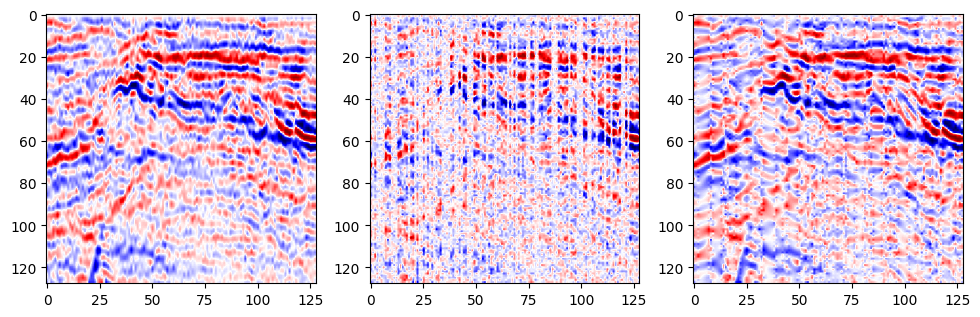

In [217]:
data = np.load('samples/copaint_mask:0.4_noise:0.1_0_1/sample0.npz')
plt.figure(figsize=(16,64))
plt.subplot(1,4,1)
plt.imshow(data['original'], plt.cm.seismic)
plt.subplot(1,4,2)
plt.imshow(data['masked_image'], plt.cm.seismic)
plt.subplot(1,4,3)
plt.imshow(data['diffusion_sample'], plt.cm.seismic)
# plt.subplot(1,4,4)
# plt.imshow(data['swin_sample'], plt.cm.seismic)

In [ ]:
data['masked_image'] - 

In [57]:
import torch as th
import random

In [61]:
spatial_mask = []
for i in range(10):
    mask_i = th.ones((128, 128))
    sample_idx = random.sample(range(1, 128), int((128 - 1) * 0.4))
    for j in sample_idx:
        mask_i[:, j] = 0
    spatial_mask.append(mask_i)
spatial_mask = th.stack(spatial_mask).unsqueeze(1)

In [91]:
th.ones(10)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [82]:
mask = spatial_mask.reshape(10, -1)
missing = th.stack([th.nonzero(mask[i] == 0) for i in range(10)]).long().reshape(10, -1)

In [83]:
missing

tensor([[    4,     5,     6,  ..., 16374, 16382, 16383],
        [    8,    11,    12,  ..., 16375, 16379, 16382],
        [    1,     3,     8,  ..., 16381, 16382, 16383],
        ...,
        [    2,     3,     7,  ..., 16377, 16380, 16383],
        [    5,    10,    15,  ..., 16376, 16379, 16382],
        [   10,    14,    15,  ..., 16379, 16381, 16382]])

In [87]:
keep = th.Tensor([[i for i in range(1 * 128**2) if i not in missing[j]] for j in range(10)]).long()

In [88]:
keep

tensor([[    0,     1,     2,  ..., 16379, 16380, 16381],
        [    0,     1,     2,  ..., 16380, 16381, 16383],
        [    0,     2,     4,  ..., 16377, 16378, 16380],
        ...,
        [    0,     1,     4,  ..., 16379, 16381, 16382],
        [    0,     1,     2,  ..., 16380, 16381, 16383],
        [    0,     1,     2,  ..., 16378, 16380, 16383]])

In [41]:
from swin import SCRN, ConvTransBlock, Block, WMSA

In [53]:
swin_model = torch.load('/poc-data/pvn/model/swin-transformer/SCRN/trained_model/diffusion_settings/model_080.pth')
swin_model.to(torch.device('cuda:0'))
swin_model.eval()

SCRN(
  (m_head): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (m1): Sequential(
    (0): ConvTransBlock(
      (trans_block): Block(
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (msa): WMSA(
          (embedding_layer): Linear(in_features=32, out_features=96, bias=True)
          (linear): Linear(in_features=32, out_features=32, bias=True)
        )
        (drop_path): Identity()
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
      (conv1_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv1_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [3]:
data = np.load('samples/sample0.npz')

NameError: name 'np' is not defined

In [8]:
def normalize(image):
    """Basic min max scaler.
    """
    min_ = np.min(image)
    max_ = np.max(image)
    scale = max_ - min_
    image = (image - min_) / scale
    image = image * 2 - 1
    return image

In [5]:
out = swin_model(torch.tensor(normalize(data['masked_image'])).permute(2,0,1).unsqueeze(0).to(torch.float32).to(torch.device('cuda:0')))

NameError: name 'swin_model' is not defined

In [49]:
data['masked_image'].shape

(128, 128, 1)

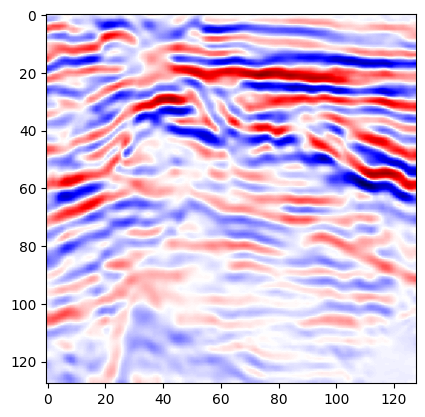

In [67]:
plt.imshow(out.cpu().detach().numpy()[0][0], plt.cm.seismic)

In [9]:
import scipy

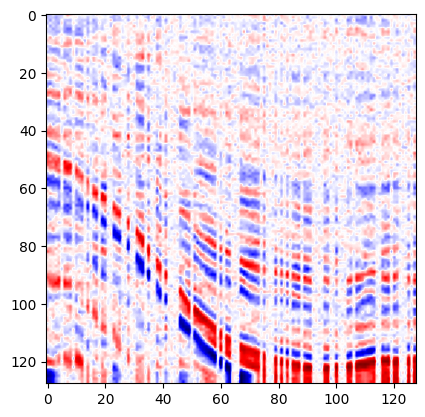

In [232]:
plt.imshow(data['masked_image'], plt.cm.seismic)

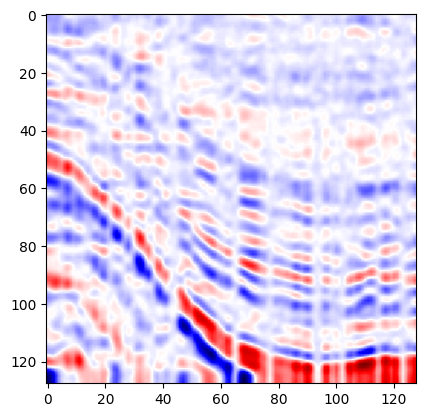

In [238]:
s = scipy.ndimage.gaussian_filter(data['masked_image'][:, :, 0], 1)
plt.imshow(s, plt.cm.seismic)

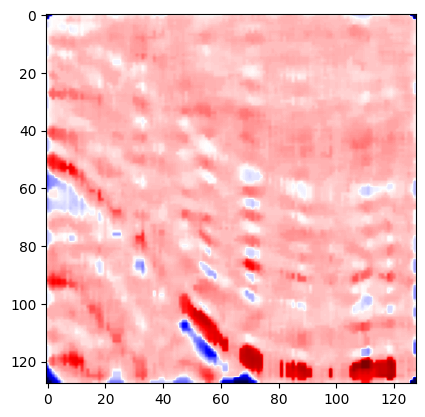

In [230]:
s = scipy.signal.median_filt(data['masked_image'][:, :, 0], 0.25)
plt.imshow(s, plt.cm.seismic)

In [10]:
from wavelet_util import DWT_2D
dwt = DWT_2D('haar')

In [13]:
xLL, xLH, xHL, xHH = dwt(torch.tensor(normalize(data['masked_image'])).permute(2,0,1).unsqueeze(0).to(torch.float32).to(torch.device('cuda:0')))

x = torch.cat((xLL, xLH, xHL, xHH), dim=1) / 2.0

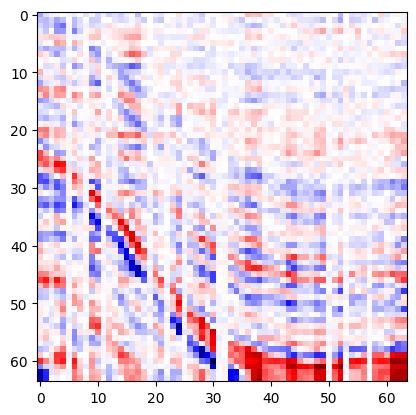

In [14]:
plt.imshow(x.cpu()[0][0], plt.cm.seismic)

In [439]:
from piq import SSIMLoss

In [464]:
ssimloss = SSIMLoss(x, data_range=-2.0 )

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [463]:
ssimloss(x,x+0.2)

tensor(0.8429, device='cuda:0')

In [15]:
from ssim_util import SSIM

In [16]:
ssim_loss = SSIM(11, size_average=True)

In [18]:
ssim_loss(x, x+0.2)

tensor([[-0.0343, -0.0163, -0.0024,  0.0054]], device='cuda:0')